# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='~/../images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='~/../images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!

# Step 0: Business Understanding

### Baseline data/analysis definitions

I will be selecting zip codes based off of average home value using information from Zillow.

A "good" zip code will be determined assuming we are interested in renting these properties. 

Return will be calculated assuming the properties will be purchased outright, monthly rent will be set at 1%, annual cost of maintenance will be 1% of the property value, and we are aiming for a 5-7 year selling strategy.

ROI example is that for a 325,000 home, charging 3,250 a month in rent, 3,250 annual in maintenance:

(3,250 x 12) - 3,250 = 35,750 / 325,000 = 11% return

General practice states that a return of 6-12% is great, so we would be happy with that.

We'll also be concerned with the general appreciation of the housing market in that zip code, with the intention of seeing at least 10% of increase in the home price over that time frame.


### Potential markets for investigation

According to a US News report in May 2019, these were among the ten cities with the top growth between 2017-2018:

- Provo-Orem, Utah - 2.6% growth, growth is driven by booming tech sector. Salt Lake County has experienced a housing shortage driving people to PO.
- Bend-Redmond, Oregon - 22% growth between 2010 and 2018.
- Boise City, Idaho - 2.9% growth, largely driven by Californian migration
- Greeley, Colorado - 3.0% growth, 24% between 2010 and 2018
- The Villages, Florida - grew by 38% between 2010 and 2018
- Odessa, Texas - 3.2% growth, the oil industry is attracting workers
- Midland, Texas - 4.3% growth, driven mostly by job growth


### Sources

https://www.usnews.com/news/cities/slideshows/new-census-estimates-reveal-the-fastest-growing-cities-in-america?slide=13

https://www.mashvisor.com/blog/average-return-on-investment-us-real-estate-market/

https://www.google.com/search?q=how+much+money+should+a+rental+property+have+in+expenses&rlz=1C1CHBF_enUS858US858&oq=how+much+money+should+a+rental+property+have+in+expen&aqs=chrome.1.69i57j33l2.21976j0j7&sourceid=chrome&ie=UTF-8


# Step 1: Load the Data/Filtering for Chosen Zipcodes

## Dictionaries

Import and use Folium

In [ ]:
import folium
import json
from folium import plugins
import os
print(folium.__version__)

In [198]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
import seaborn as sns
sns.set(style="whitegrid")

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_model import ARMA

import itertools
import warnings
warnings.filterwarnings("ignore")

In [199]:
df = pd.read_csv('zillow_data.csv')
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


## Filtering

In [200]:
#Provo-Orem UT
provooremUT = ['84097', '84601', '84604', '84606', '84663', '84057', '84058']

#Bend-Redmond OR
bendOR = ['97701', '97702', '97703', '97756']

#Boise City, ID
boiseID = ['83702', '83703', '83704', '83705', '83706', '83709', '83712', 
           '83713', '83714', '83716']

#Greeley, CO
greeleyCO = ['80543', '80550', '80620', '80631', '80634']

#The Villages, FL
villagesFL = ['32159', '32162', '32163', '34484', '34731', '34785']

#Midlane - Odessa, TX
midlandTX = ['79761', '79762', '79763', '79764', '79765', '79766']

In [201]:
a = []
zc = [provooremUT, bendOR, boiseID, greeleyCO, villagesFL, midlandTX]
for b in zc:
    c = [a,b]
    a = list(itertools.chain.from_iterable(c))
    
data = df[df['RegionName'].isin(a)]

In [202]:
data.isna().sum().value_counts()

0    272
dtype: int64

# Step 2: Data Preprocessing

In [203]:
def get_datetimes(data):
    return pd.to_datetime(data.columns.values[7:], format='%Y-%m')

In [204]:
get_datetimes(data)

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

In [205]:
cols = list(data.columns[7:172])

In [206]:
provo = data[data['RegionName'].isin(provooremUT)]
provo = provo.set_index(['RegionName'])
provo = provo.drop(['RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], axis=1)
provo = provo.drop(cols, axis=1)

In [207]:
bend = data[data['RegionName'].isin(bendOR)]
bend = bend.set_index(['RegionName'])
bend = bend.drop(['RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], axis=1)
bend = bend.drop(cols, axis=1)

In [208]:
boise = data[data['RegionName'].isin(boiseID)]
boise = boise.set_index(['RegionName'])
boise = boise.drop(['RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], axis=1)
boise = boise.drop(cols, axis=1)

In [209]:
greeley = data[data['RegionName'].isin(greeleyCO)]
greeley = greeley.set_index(['RegionName'])
greeley = greeley.drop(['RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], axis=1)
greeley = greeley.drop(cols, axis=1)

In [210]:
villages = data[data['RegionName'].isin(villagesFL)]
villages = villages.set_index(['RegionName'])
villages = villages.drop(['RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], axis=1)
villages = villages.drop(cols, axis=1)

In [211]:
midland = data[data['RegionName'].isin(midlandTX)]
midland = midland.set_index(['RegionName'])
midland = midland.drop(['RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], axis=1)
midland = midland.drop(cols, axis=1)

# Step 3: EDA and Visualization

In [212]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}

plt.rc('font', **font)

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

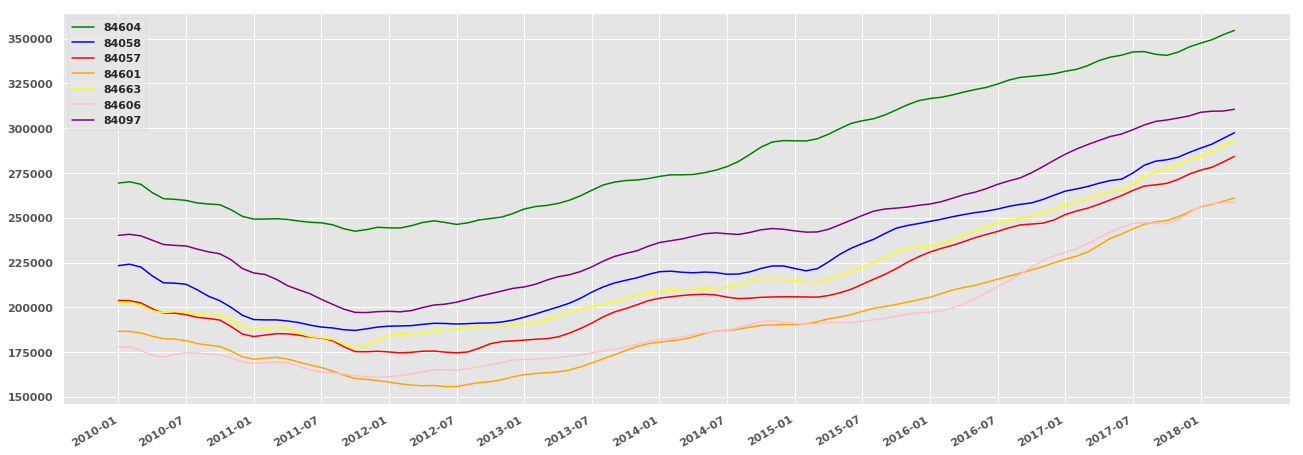

In [213]:
plt.figure(figsize=(22,8))
plt.style.use('ggplot')

x = provo.columns
a = provo.loc[84604]
b = provo.loc[84058] 
c = provo.loc[84057] 
d = provo.loc[84601] 
e = provo.loc[84663] 
f = provo.loc[84606]
g = provo.loc[84097]

plt.plot(x, a, 'green')
plt.plot(x, b, 'blue')
plt.plot(x, c, 'red')
plt.plot(x, d, 'orange')
plt.plot(x, e, 'yellow')
plt.plot(x, f, 'pink')
plt.plot(x, g, 'purple')

plt.gcf().autofmt_xdate()
plt.xticks(provo.columns[::6])
plt.legend(loc='best')
plt.show();

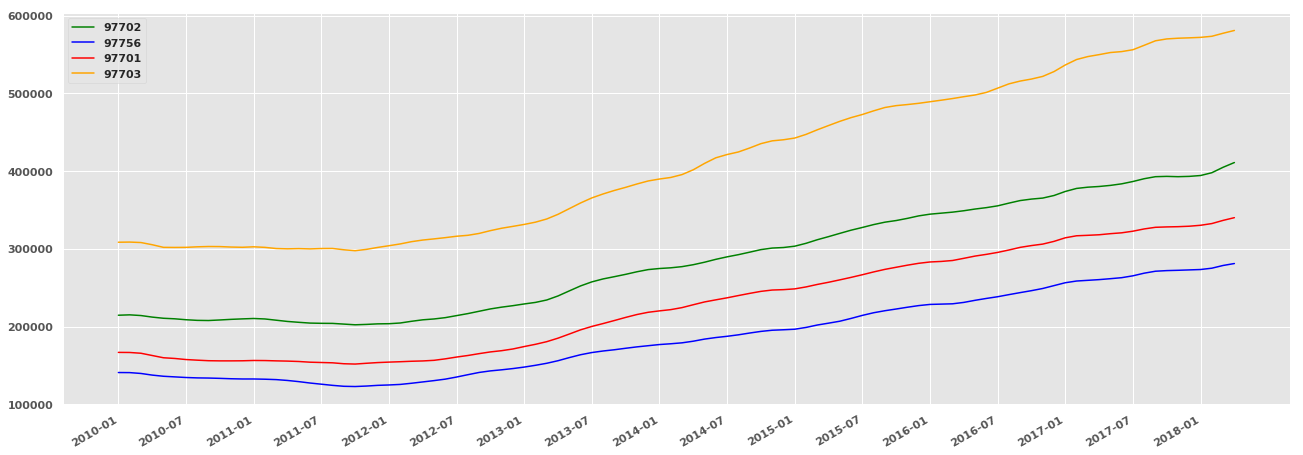

In [175]:
plt.figure(figsize=(22,8))
plt.style.use('ggplot')

x = bend.columns
a = bend.loc[97702]
b = bend.loc[97756]
c = bend.loc[97701]
d = bend.loc[97703]

plt.plot(x, a, 'green')
plt.plot(x, b, 'blue')
plt.plot(x, c, 'red')
plt.plot(x, d, 'orange')

plt.gcf().autofmt_xdate()
plt.xticks(bend.columns[::6])
plt.legend(loc='best')
plt.show();

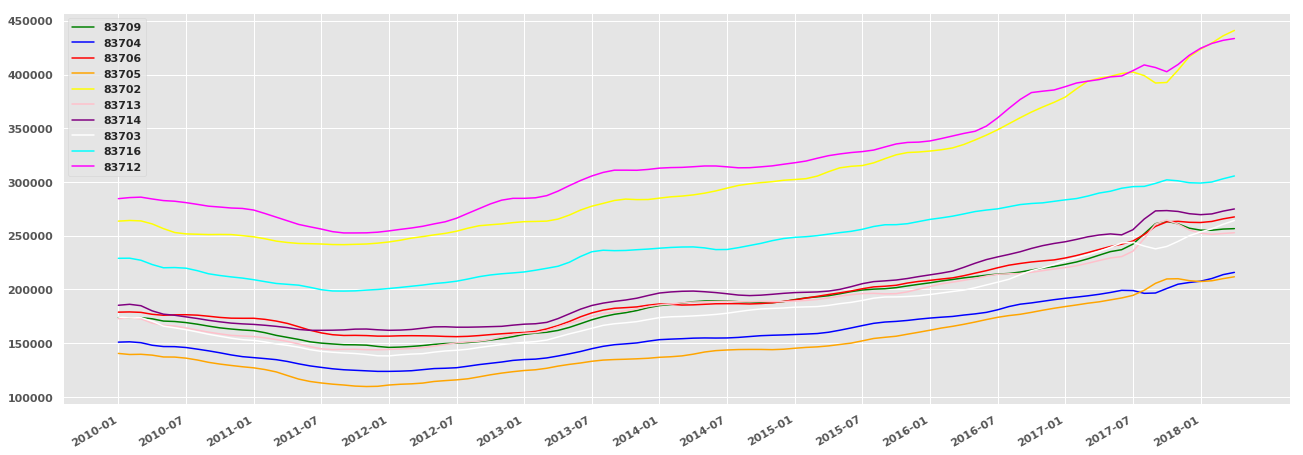

In [176]:
plt.figure(figsize=(22,8))
plt.style.use('ggplot')

x = boise.columns
a = boise.loc[83709]
b = boise.loc[83704]
c = boise.loc[83706]
d = boise.loc[83705]
e = boise.loc[83702]
f = boise.loc[83713]
g = boise.loc[83714]
h = boise.loc[83703]
i = boise.loc[83716]
j = boise.loc[83712]

plt.plot(x, a, 'green')
plt.plot(x, b, 'blue')
plt.plot(x, c, 'red')
plt.plot(x, d, 'orange')
plt.plot(x, e, 'yellow')
plt.plot(x, f, 'pink')
plt.plot(x, g, 'purple')
plt.plot(x, h, 'white')
plt.plot(x, i, 'cyan')
plt.plot(x, j, 'magenta')

plt.gcf().autofmt_xdate()
plt.xticks(boise.columns[::6])
plt.legend(loc='best')
plt.show();

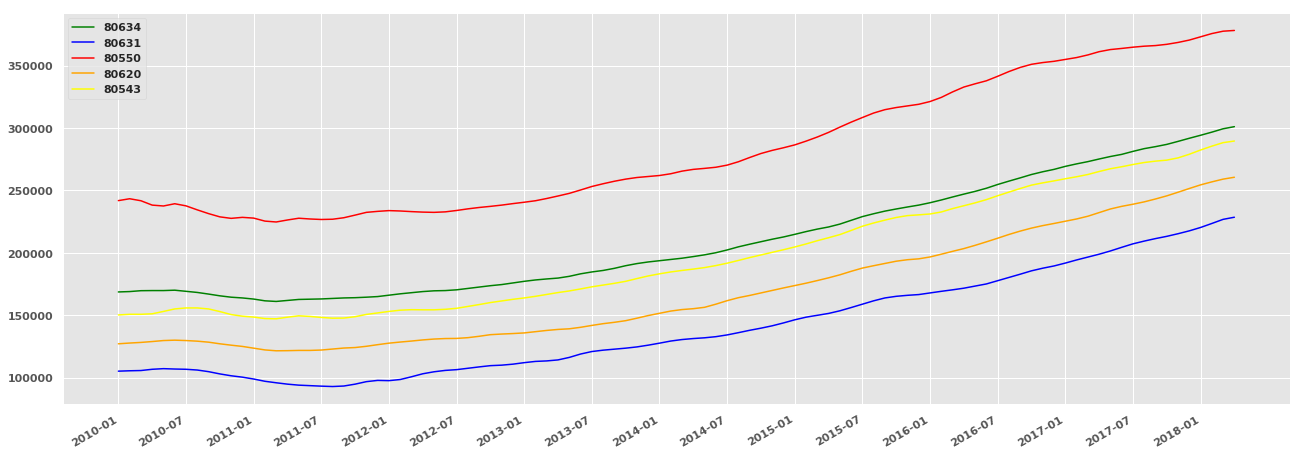

In [177]:
plt.figure(figsize=(22,8))
plt.style.use('ggplot')

x = greeley.columns
a = greeley.loc[80634]
b = greeley.loc[80631]
c = greeley.loc[80550]
d = greeley.loc[80620]
e = greeley.loc[80543]

plt.plot(x, a, 'green')
plt.plot(x, b, 'blue')
plt.plot(x, c, 'red')
plt.plot(x, d, 'orange')
plt.plot(x, e, 'yellow')

plt.gcf().autofmt_xdate()
plt.xticks(greeley.columns[::6])
plt.legend(loc='best')
plt.show();

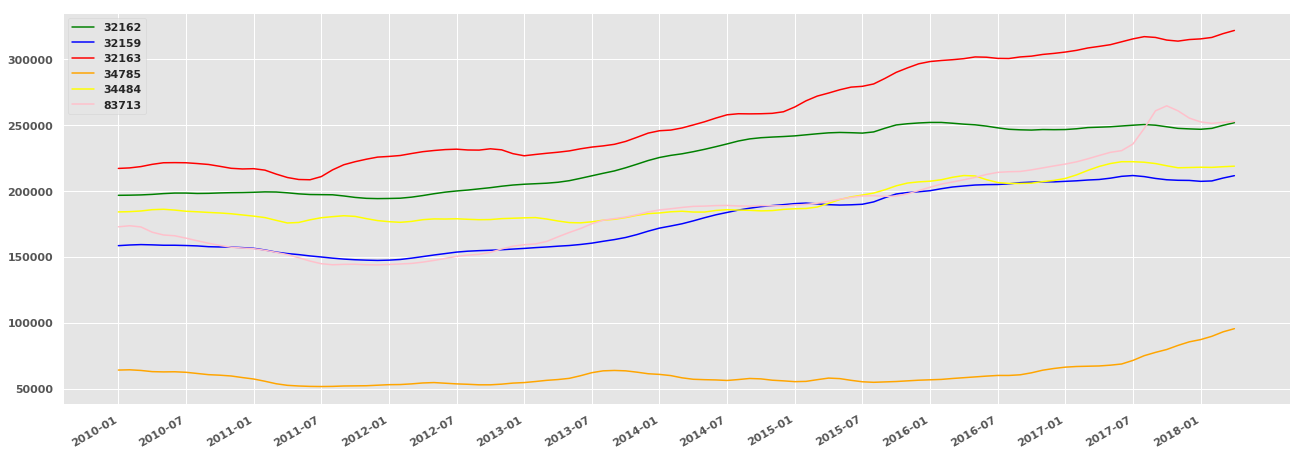

In [178]:
plt.figure(figsize=(22,8))
plt.style.use('ggplot')

x = villages.columns
a = villages.loc[32162]
b = villages.loc[32159]
c = villages.loc[32163]
d = villages.loc[34785]
e = villages.loc[34731]
e = villages.loc[34484]

plt.plot(x, a, 'green')
plt.plot(x, b, 'blue')
plt.plot(x, c, 'red')
plt.plot(x, d, 'orange')
plt.plot(x, e, 'yellow')
plt.plot(x, f, 'pink')

plt.gcf().autofmt_xdate()
plt.xticks(villages.columns[::6])
plt.legend(loc='best')
plt.show();

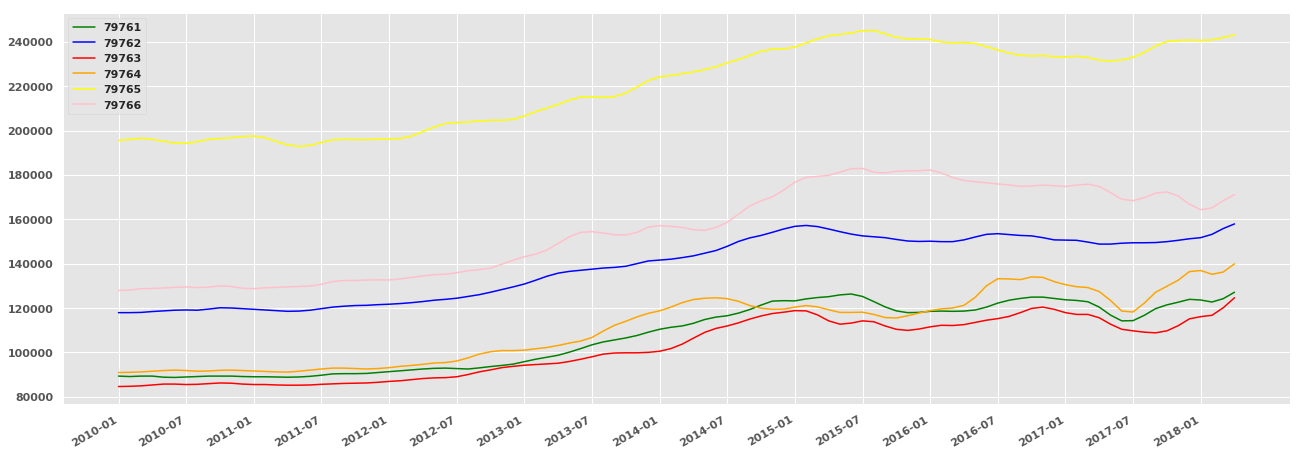

In [179]:
plt.figure(figsize=(22,8))
plt.style.use('ggplot')

x = midland.columns
a = midland.loc[79761]
b = midland.loc[79762]
c = midland.loc[79763]
d = midland.loc[79764]
e = midland.loc[79765]
f = midland.loc[79766]

plt.plot(x, a, 'green')
plt.plot(x, b, 'blue')
plt.plot(x, c, 'red')
plt.plot(x, d, 'orange')
plt.plot(x, e, 'yellow')
plt.plot(x, f, 'pink')

plt.gcf().autofmt_xdate()
plt.xticks(midland.columns[::6])
plt.legend(loc='best')
plt.show();

To make a selection, I want to calculate an annual appraisal - based on the avg January price. 

In [214]:
yr = {2010: '2010-01', 2011: '2011-01', 2012: '2012-01', 2013: '2013-01', 2014: '2014-01', 2015: '2015-01', 2016: '2016-01', 2017: '2017-01'}
def year_bought(year, df):
    year2 = year+1
    rate = (df[yr[year2]] - df[yr[year]]) / df[yr[year]]
    return rate

In [215]:
year_bought(2010, midland)

RegionName
79762    0.012723
79763    0.010638
79761   -0.003359
79764    0.007701
79765    0.010230
79766    0.006255
dtype: float64

In [216]:
#This code will calculate the average annual value of the property. I'll use 
#this to select the average home value change YOY. Zips with the largest avg
#annual growth will be selected for modeling.
yrs = ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']
sets = [provo, bend, boise, greeley, villages, midland]
mos = ['-01', '-02', '-03', '-04', '-05', '-06', '-07', '-08', '-09', '-10', 
       '-11', '-12']

for i in sets:
    for j in yrs:
        k = []
        for l in mos:
            m = j + l
            k.append(i[m])
            annual_avg = sum(k)/12
            i[j] = annual_avg

In [220]:
time = []
for i in provo.columns[100:]:
    time.append(i)
    
pvo = provo.reset_index()
pvo = pd.melt(pvo, id_vars=['RegionName'], value_vars=time)
pvo = pvo.sort_values(by=['variable', 'value'])
pvo.RegionName = pvo.RegionName.astype('str')

In [221]:
pvo

,RegionName,variable,value
5,84606,2010,174108.333333
3,84601,2010,181158.333333
2,84057,2010,196191.666667
4,84663,2010,197191.666667
1,84058,2010,211908.333333
6,84097,2010,233675.000000
0,84604,2010,260966.666667
12,84606,2011,165250.000000
10,84601,2011,166291.666667
9,84057,2011,181241.666667


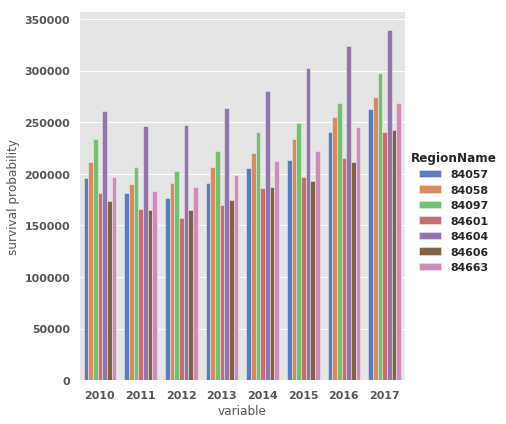

In [222]:
g = sns.catplot(x="variable", y="value", hue="RegionName", data=pvo,
                height=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("survival probability")

In [185]:
provo

,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,...,2018-03,2018-04,2010,2011,2012,2013,2014,2015,2016,2017
RegionName,,,,,,,,,,,,,,,,,,,,,
84604,269400.0,270100.0,268700.0,264100.0,260700.0,260300.0,259700.0,258300.0,257700.0,257300.0,...,352200,354600,260966.666667,246725.000000,247675.000000,263800.000000,280600.000000,302900.000000,323841.666667,339441.666667
84058,223300.0,224100.0,222500.0,217600.0,213700.0,213500.0,212900.0,209800.0,206200.0,203700.0,...,294300,297500,211908.333333,190191.666667,190858.333333,206683.333333,220241.666667,233600.000000,254675.000000,274900.000000
84057,203900.0,203700.0,202500.0,199300.0,196700.0,196800.0,195900.0,194400.0,193800.0,192900.0,...,281100,284300,196191.666667,181241.666667,176625.000000,190950.000000,205991.666667,213691.666667,240816.666667,263116.666667
84601,186600.0,186600.0,185700.0,183900.0,182500.0,182300.0,181400.0,179800.0,178900.0,178200.0,...,259200,261100,181158.333333,166291.666667,157550.000000,169358.333333,186175.000000,196975.000000,215091.666667,240891.666667
84663,202700.0,202800.0,201100.0,198200.0,197000.0,197700.0,197300.0,196100.0,195700.0,195400.0,...,290200,293200,197191.666667,183700.000000,187533.333333,199366.666667,212033.333333,222508.333333,244958.333333,268825.000000
84606,178000.0,178000.0,176000.0,173100.0,172200.0,173900.0,174600.0,174500.0,174000.0,173500.0,...,258200,258700,174108.333333,165250.000000,165433.333333,174725.000000,187333.333333,192858.333333,211033.333333,242808.333333
84097,240200.0,240800.0,239900.0,237500.0,235100.0,234600.0,234300.0,232500.0,231000.0,229900.0,...,309600,310600,233675.000000,206658.333333,203116.666667,222283.333333,240708.333333,249458.333333,268200.000000,297683.333333


In [223]:
growth = ['2010', '2011', '2012', '2013', '2014', '2015', '2016']
for a, b in enumerate(growth, 2011):
    cols = []
    col = str(a)+'-YOY_Delta'
    provo[col] = ((provo[str(a)] - provo[b]) / provo[b])
    cols.append(provo[col])

In [224]:
provo

,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,...,2015,2016,2017,2011-YOY_Delta,2012-YOY_Delta,2013-YOY_Delta,2014-YOY_Delta,2015-YOY_Delta,2016-YOY_Delta,2017-YOY_Delta
RegionName,,,,,,,,,,,,,,,,,,,,,
84604,269400.0,270100.0,268700.0,264100.0,260700.0,260300.0,259700.0,258300.0,257700.0,257300.0,...,302900.000000,323841.666667,339441.666667,-0.054573,0.003850,0.065105,0.063685,0.079473,0.069137,0.048172
84058,223300.0,224100.0,222500.0,217600.0,213700.0,213500.0,212900.0,209800.0,206200.0,203700.0,...,233600.000000,254675.000000,274900.000000,-0.102481,0.003505,0.082915,0.065600,0.060653,0.090218,0.079415
84057,203900.0,203700.0,202500.0,199300.0,196700.0,196800.0,195900.0,194400.0,193800.0,192900.0,...,213691.666667,240816.666667,263116.666667,-0.076201,-0.025472,0.081104,0.078773,0.037380,0.126935,0.092602
84601,186600.0,186600.0,185700.0,183900.0,182500.0,182300.0,181400.0,179800.0,178900.0,178200.0,...,196975.000000,215091.666667,240891.666667,-0.082064,-0.052568,0.074950,0.099296,0.058010,0.091974,0.119949
84663,202700.0,202800.0,201100.0,198200.0,197000.0,197700.0,197300.0,196100.0,195700.0,195400.0,...,222508.333333,244958.333333,268825.000000,-0.068419,0.020867,0.063100,0.063535,0.049403,0.100895,0.097432
84606,178000.0,178000.0,176000.0,173100.0,172200.0,173900.0,174600.0,174500.0,174000.0,173500.0,...,192858.333333,211033.333333,242808.333333,-0.050878,0.001109,0.056166,0.072161,0.029493,0.094240,0.150569
84097,240200.0,240800.0,239900.0,237500.0,235100.0,234600.0,234300.0,232500.0,231000.0,229900.0,...,249458.333333,268200.000000,297683.333333,-0.115616,-0.017138,0.094363,0.082890,0.036351,0.075129,0.109930


In [192]:
provo.columns[108:]

Index(['2011-YOY_Delta', '2012-YOY_Delta', '2013-YOY_Delta', '2014-YOY_Delta',
       '2015-YOY_Delta', '2016-YOY_Delta', '2017-YOY_Delta'],
      dtype='object')

In [225]:
provo['Avg_YOY_growth'] = (provo['2011-YOY_Delta'] + provo['2012-YOY_Delta'] + 
                           provo['2013-YOY_Delta'] + provo['2014-YOY_Delta'] + 
                           provo['2015-YOY_Delta'] + provo['2016-YOY_Delta'] + 
                           provo['2017-YOY_Delta']) / 7

provo.sort_values('Avg_YOY_growth')

,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,...,2016,2017,2011-YOY_Delta,2012-YOY_Delta,2013-YOY_Delta,2014-YOY_Delta,2015-YOY_Delta,2016-YOY_Delta,2017-YOY_Delta,Avg_YOY_growth
RegionName,,,,,,,,,,,,,,,,,,,,,
84097,240200.0,240800.0,239900.0,237500.0,235100.0,234600.0,234300.0,232500.0,231000.0,229900.0,...,268200.000000,297683.333333,-0.115616,-0.017138,0.094363,0.082890,0.036351,0.075129,0.109930,0.037987
84604,269400.0,270100.0,268700.0,264100.0,260700.0,260300.0,259700.0,258300.0,257700.0,257300.0,...,323841.666667,339441.666667,-0.054573,0.003850,0.065105,0.063685,0.079473,0.069137,0.048172,0.039264
84058,223300.0,224100.0,222500.0,217600.0,213700.0,213500.0,212900.0,209800.0,206200.0,203700.0,...,254675.000000,274900.000000,-0.102481,0.003505,0.082915,0.065600,0.060653,0.090218,0.079415,0.039975
84601,186600.0,186600.0,185700.0,183900.0,182500.0,182300.0,181400.0,179800.0,178900.0,178200.0,...,215091.666667,240891.666667,-0.082064,-0.052568,0.074950,0.099296,0.058010,0.091974,0.119949,0.044221
84057,203900.0,203700.0,202500.0,199300.0,196700.0,196800.0,195900.0,194400.0,193800.0,192900.0,...,240816.666667,263116.666667,-0.076201,-0.025472,0.081104,0.078773,0.037380,0.126935,0.092602,0.045017
84663,202700.0,202800.0,201100.0,198200.0,197000.0,197700.0,197300.0,196100.0,195700.0,195400.0,...,244958.333333,268825.000000,-0.068419,0.020867,0.063100,0.063535,0.049403,0.100895,0.097432,0.046687
84606,178000.0,178000.0,176000.0,173100.0,172200.0,173900.0,174600.0,174500.0,174000.0,173500.0,...,211033.333333,242808.333333,-0.050878,0.001109,0.056166,0.072161,0.029493,0.094240,0.150569,0.050408


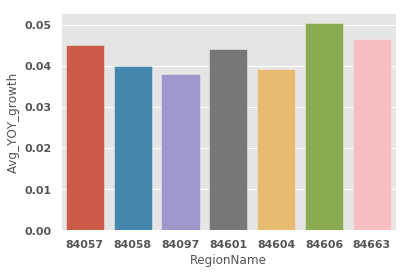

In [240]:
ax = sns.barplot(x=provo.index, y="Avg_YOY_growth", data=provo)


In [ ]:
for s in sets:
    for a, b in enumerate(yrs, 2011):
        s['Avg_Annual'] = 

In [ ]:
growth = ['2010', '2011', '2012', '2013', '2014', '2015', '2016']

for s in sets:
    for a, b in enumerate(growth, 2011):
        cols = []
        col = str(a)+'-YOY_Delta'
        s[col] = ((s[str(a)] - s[b]) / s[b])
        cols.append(s[col])
    s['Avg_seven_yr_growth'] = sum(cols)/7

In [ ]:
midland

In [ ]:
midland.columns[-10:-1]

In [ ]:
midland['col'] = (midland['2011-YOY_Delta'] + midland['2012-YOY_Delta'] + 
                 midland['2013-YOY_Delta'] + midland['2014-YOY_Delta'] +
                 midland['2015-YOY_Delta'] + midland['2016-YOY_Delta'] + 
                 midland['2017-YOY_Delta']) / 7
midland

In [ ]:
def annual_averages(year, places):
    
    for i in places:
        i[year] = 

# Step 4: Reshape from Wide to Long Format

In [ ]:
# def melt_data(df):
#     melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
#     melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
#     melted = melted.dropna(subset=['value'])
#     return melted.groupby('time').aggregate({'value':'mean'})

In [25]:
df = pd.read_csv('zillow_data.csv')

time = []
for i in df.columns[7:]:
    time.append(i)
    
data2 = pd.melt(df, id_vars=['RegionName'], value_vars=time)
data2 = data2.sort_values(by=['RegionName', 'variable'])
data2.variable = pd.to_datetime(data2.variable, format='%Y-%m')
data2.set_index('variable', inplace=True)
data2.RegionName = data2.RegionName.astype('str')
data2.head()

,RegionName,value
variable,,
1996-04-01,1001,113100.0
1996-05-01,1001,112800.0
1996-06-01,1001,112600.0
1996-07-01,1001,112300.0
1996-08-01,1001,112100.0


In [26]:
mld = data2[data2['RegionName'] == '79764']
mld = mld['2010':]

# Step 5: ARIMA Modeling

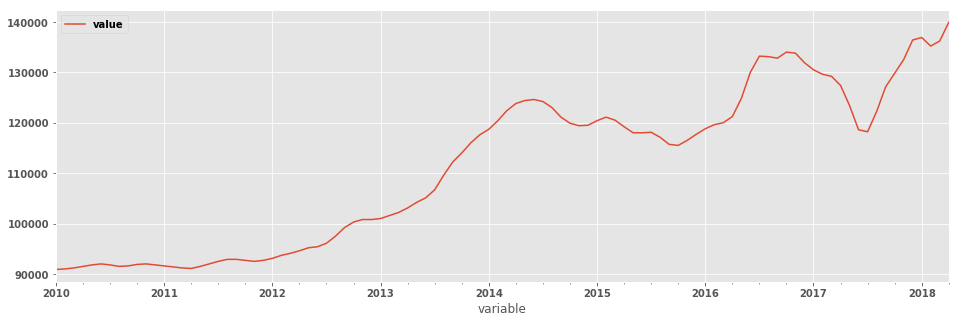

In [27]:
mld.plot(figsize=(16,5), linewidth=1.5, fontsize=10);

In [28]:
mld = mld.drop(['RegionName'], axis=1)

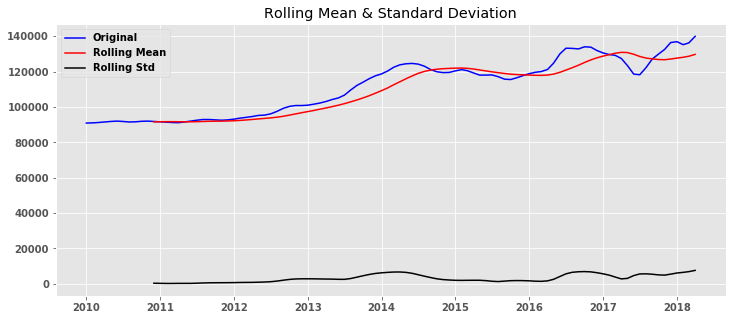

In [29]:
rolmean = mld.rolling(window = 12, center = False).mean()
rolstd = mld.rolling(window = 12, center = False).std()

fig = plt.figure(figsize=(12,5))
orig = plt.plot(mld, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show();

Looking at the plot of the zip code, we can see three things.
- The mean (red line) increases over time.
- The variance appears to increase over time - for the first three years the line is relatively straight, then it starts to fluctuate.
- The covariance is a function of time - the waves of the blue line get more frequent.

Each of these point to the fact that the time series is not stationary.

It would appear that the trend is upward and relatively linear with increasing variance. It also appears there is a growing periodic trend in the mean price on an annual basis.

In [30]:
#Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(mld['value'])

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                 -0.229391
p-value                         0.934926
#Lags Used                      4.000000
Number of Observations Used    95.000000
Critical Value (1%)            -3.501137
Critical Value (5%)            -2.892480
Critical Value (10%)           -2.583275
dtype: float64


The test statistic is not less than the critical value and the p-value is not significant at the 5% level, meaning we fail to reject the null hypothesis that the time series is stationary. This means we will need to adjust for the trends present in the data.

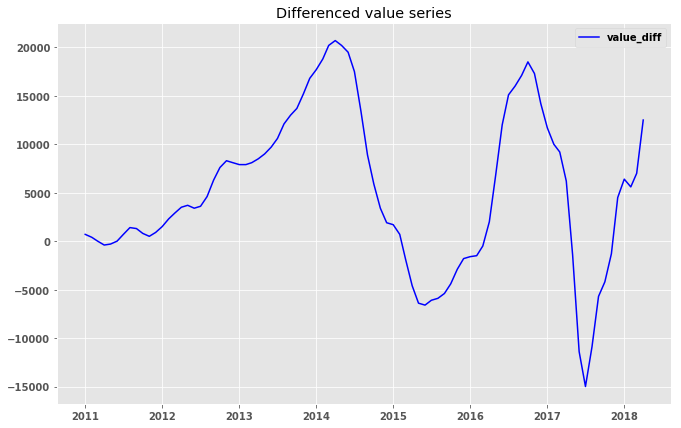

In [75]:
mld_diff = mld.diff(periods=12).dropna()
fig = plt.figure(figsize=(11,7))
plt.plot(mld_diff, color='blue',label='value_diff')
plt.legend(loc='best')
plt.title('Differenced value series')
plt.show(block=False)

In [ ]:
decomposition = seasonal_decompose(np.log(mld))

# Gather the trend, seasonality and noise of decomposed object
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(np.log(mld), label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.tight_layout()

We see an upward, somewhat linear trend. There is slight seasonality, but notice the slightness of the y-axis. The residuals indicate increased variability in value in more recent years.

In [ ]:
def stationarity_check(mld):
    
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    rolmean = mld.rolling(window = 8, center = False).mean()
    rolstd = mld.rolling(window = 8, center = False).std()
    
    # Perform the Dickey Fuller Test
    dftest = adfuller(mld['value']) # change the passengers column as required 
    
    #Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(mld, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print ('Results of Dickey-Fuller Test:')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    return None

In [ ]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)

# Check stationarity
stationarity_check(ts_log_decompose)

By differencing the data by 12 months, we remove the cyclical seasonality of the data. Therefore, we are comparing January prices in one year to January prices of the next, so instead of comparing how one month prior might impact the current month price, we are comparing one year to the next. Therefore we see a true fluctuation of a local housing market over time.

In [ ]:
#Autocorrelation
mld_lag1 = mld.shift(periods=1)
lag1 = pd.concat([mld_lag1, mld], axis=1)
lag1.corr()

In [ ]:
mld_lag12 = mld.shift(periods=12)
lag12 = pd.concat([mld_lag12, mld], axis=1)
lag12.corr()

Relatively high autocorrelation on a 12-period lag. Much stronger autocorrelation on a 1-month lag.

In [ ]:
plt.figure(figsize=(12,5))
pd.plotting.autocorrelation_plot(mld);

The above plot shows there is significance in the autocorrelation up to about 22 months of lag

In [ ]:
mld_diff_ac = mld_diff.dropna()
plt.figure(figsize=(12,5))
pd.plotting.autocorrelation_plot(mld_diff_ac);

Here we see significance for the first few months lag (5-6) and then again for 11-12.

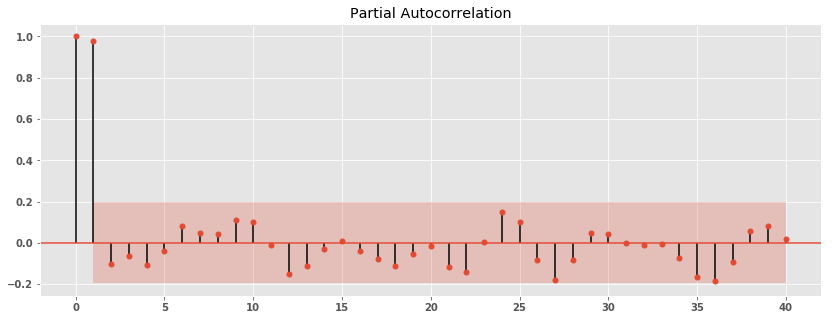

In [31]:
rcParams['figure.figsize'] = 14, 5

plot_pacf(mld, lags = 40);

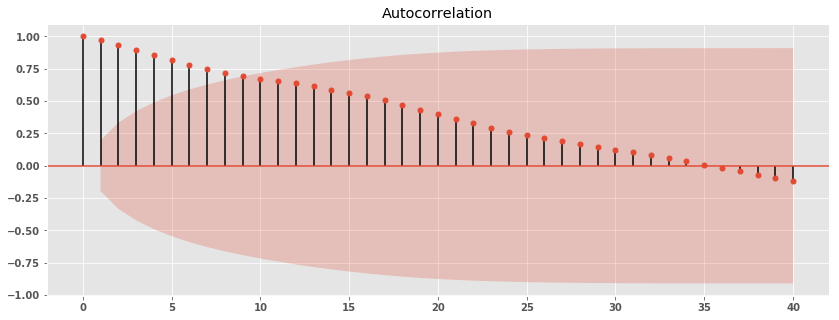

In [32]:
rcParams['figure.figsize'] = 14, 5

plot_acf(mld, lags = 40);

We would say that the ARMA(p,q) would be AR(0-1)(PACF), MA(0-7)(ACF)

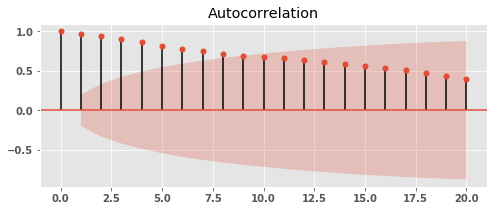

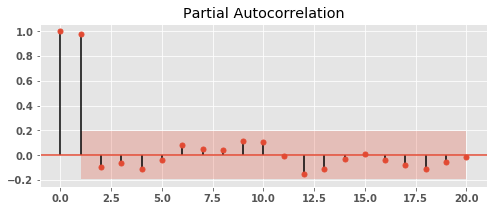

In [33]:
fig, ax = plt.subplots(figsize=(8,3))
plot_acf(mld,ax=ax, lags=20)

fig, ax = plt.subplots(figsize=(8,3))
plot_pacf(mld,ax=ax, lags=20);

In [76]:
# Fit an ARMA(2,1) model to the first simulated data
mod_arma = ARMA(mld_diff, order=(2,2))
res_arma = mod_arma.fit()

# Print out summary information on the fit
print(res_arma.summary())

# Print out the estimate for the constant and for theta
print(res_arma.params)

ValueError: The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.

In [51]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0,3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [52]:
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(mld,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =2586.184791517919
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =2227.727834820182
ARIMA (0, 0, 0) x (0, 0, 2, 12)12 : AIC Calculated =1886.0773020982588
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =1844.7308893996506
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =1603.5289304242433
ARIMA (0, 0, 0) x (0, 1, 2, 12)12 : AIC Calculated =1499.7635197782627
ARIMA (0, 0, 0) x (0, 2, 0, 12)12 : AIC Calculated =1642.3417963884576
ARIMA (0, 0, 0) x (0, 2, 1, 12)12 : AIC Calculated =1388.1214432028821
ARIMA (0, 0, 0) x (0, 2, 2, 12)12 : AIC Calculated =2155.088275620497
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =1840.7471768892135
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =1821.7353767954228
ARIMA (0, 0, 0) x (1, 0, 2, 12)12 : AIC Calculated =1533.2542625356327
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =1623.250621952284
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =1586.0052938026279
ARIMA (0, 

ARIMA (0, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =1425.0076525781653
ARIMA (0, 1, 1) x (1, 0, 2, 12)12 : AIC Calculated =1237.6067786487924
ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =1329.104228594619
ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =1278.2122368850823
ARIMA (0, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =5056.502680490657
ARIMA (0, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =1175.9557141465061
ARIMA (0, 1, 1) x (1, 2, 1, 12)12 : AIC Calculated =1143.7378703355498
ARIMA (0, 1, 1) x (1, 2, 2, 12)12 : AIC Calculated =4016.5194784993478
ARIMA (0, 1, 1) x (2, 0, 0, 12)12 : AIC Calculated =1266.8354339936727
ARIMA (0, 1, 1) x (2, 0, 1, 12)12 : AIC Calculated =1268.7549511927464
ARIMA (0, 1, 1) x (2, 0, 2, 12)12 : AIC Calculated =1239.0502123581257
ARIMA (0, 1, 1) x (2, 1, 0, 12)12 : AIC Calculated =1098.0536604240342
ARIMA (0, 1, 1) x (2, 1, 1, 12)12 : AIC Calculated =1099.0416217914083
ARIMA (0, 1, 1) x (2, 1, 2, 12)12 : AIC Calculated =5043.178147071967
ARIMA (0,

ARIMA (0, 2, 2) x (2, 0, 2, 12)12 : AIC Calculated =1186.2429293205153
ARIMA (0, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =1085.7525440386034
ARIMA (0, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =1081.3324915790458
ARIMA (0, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =4975.538878258268
ARIMA (0, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =911.3185869044987
ARIMA (0, 2, 2) x (2, 2, 1, 12)12 : AIC Calculated =902.7211376479034
ARIMA (0, 2, 2) x (2, 2, 2, 12)12 : AIC Calculated =852.958640943378
ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =1738.6329616707571
ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =1586.1621569822148
ARIMA (1, 0, 0) x (0, 0, 2, 12)12 : AIC Calculated =1308.5269637414156
ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =1604.8695925414536
ARIMA (1, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =1387.668846996783
ARIMA (1, 0, 0) x (0, 1, 2, 12)12 : AIC Calculated =2468.559643220847
ARIMA (1, 0, 0) x (0, 2, 0, 12)12 : AIC Calculated =1452.8925144729455
ARIMA (1, 0, 

ARIMA (1, 1, 1) x (0, 0, 2, 12)12 : AIC Calculated =1204.624525665157
ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =1491.4080168921053
ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =1260.7828457731205
ARIMA (1, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =2402.662160976854
ARIMA (1, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =1335.1264874545109
ARIMA (1, 1, 1) x (0, 2, 1, 12)12 : AIC Calculated =1122.5010763755422
ARIMA (1, 1, 1) x (0, 2, 2, 12)12 : AIC Calculated =2168.3256737086517
ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated =1419.010354947531
ARIMA (1, 1, 1) x (1, 0, 1, 12)12 : AIC Calculated =1393.077857349734
ARIMA (1, 1, 1) x (1, 0, 2, 12)12 : AIC Calculated =1206.4776360033707
ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated =1280.493470777224
ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =1258.5433615697593
ARIMA (1, 1, 1) x (1, 1, 2, 12)12 : AIC Calculated =nan
ARIMA (1, 1, 1) x (1, 2, 0, 12)12 : AIC Calculated =1124.146835868468
ARIMA (1, 1, 1) x (1, 2, 1,

ARIMA (1, 2, 2) x (1, 0, 2, 12)12 : AIC Calculated =1173.938842239291
ARIMA (1, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =1277.3069155096878
ARIMA (1, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =1233.7975925683263
ARIMA (1, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =4757.373600141167
ARIMA (1, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =1116.0109059461595
ARIMA (1, 2, 2) x (1, 2, 1, 12)12 : AIC Calculated =1080.8786101081735
ARIMA (1, 2, 2) x (1, 2, 2, 12)12 : AIC Calculated =3855.901485697362
ARIMA (1, 2, 2) x (2, 0, 0, 12)12 : AIC Calculated =1209.8871873175278
ARIMA (1, 2, 2) x (2, 0, 1, 12)12 : AIC Calculated =1204.6997351599096
ARIMA (1, 2, 2) x (2, 0, 2, 12)12 : AIC Calculated =1191.3215472037868
ARIMA (1, 2, 2) x (2, 1, 0, 12)12 : AIC Calculated =1052.4759635450257
ARIMA (1, 2, 2) x (2, 1, 1, 12)12 : AIC Calculated =1053.4671199864254
ARIMA (1, 2, 2) x (2, 1, 2, 12)12 : AIC Calculated =2707.34479514255
ARIMA (1, 2, 2) x (2, 2, 0, 12)12 : AIC Calculated =881.0392966449921
ARIMA (1, 2,

ARIMA (2, 1, 0) x (2, 0, 2, 12)12 : AIC Calculated =1230.8307512367317
ARIMA (2, 1, 0) x (2, 1, 0, 12)12 : AIC Calculated =1059.6426404689735
ARIMA (2, 1, 0) x (2, 1, 1, 12)12 : AIC Calculated =1062.2266162507242
ARIMA (2, 1, 0) x (2, 1, 2, 12)12 : AIC Calculated =2915.5614249294185
ARIMA (2, 1, 0) x (2, 2, 0, 12)12 : AIC Calculated =885.7593796249781
ARIMA (2, 1, 0) x (2, 2, 1, 12)12 : AIC Calculated =887.6961995266339
ARIMA (2, 1, 0) x (2, 2, 2, 12)12 : AIC Calculated =891.5569378508893
ARIMA (2, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated =1596.4359941474333
ARIMA (2, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated =1392.999331007077
ARIMA (2, 1, 1) x (0, 0, 2, 12)12 : AIC Calculated =1204.329846962142
ARIMA (2, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated =1507.5881476782429
ARIMA (2, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated =1256.0247499345894
ARIMA (2, 1, 1) x (0, 1, 2, 12)12 : AIC Calculated =5096.262753677204
ARIMA (2, 1, 1) x (0, 2, 0, 12)12 : AIC Calculated =1350.9684026345062
ARIMA (2, 1,

ARIMA (2, 2, 2) x (0, 0, 2, 12)12 : AIC Calculated =1164.571673202015
ARIMA (2, 2, 2) x (0, 1, 0, 12)12 : AIC Calculated =1415.2237103407003
ARIMA (2, 2, 2) x (0, 1, 1, 12)12 : AIC Calculated =1214.4248852703276
ARIMA (2, 2, 2) x (0, 1, 2, 12)12 : AIC Calculated =2789.747371566474
ARIMA (2, 2, 2) x (0, 2, 0, 12)12 : AIC Calculated =1268.4241261745917
ARIMA (2, 2, 2) x (0, 2, 1, 12)12 : AIC Calculated =1055.708158172014
ARIMA (2, 2, 2) x (0, 2, 2, 12)12 : AIC Calculated =2127.035701890496
ARIMA (2, 2, 2) x (1, 0, 0, 12)12 : AIC Calculated =1385.2752491925526
ARIMA (2, 2, 2) x (1, 0, 1, 12)12 : AIC Calculated =1352.5356605723405
ARIMA (2, 2, 2) x (1, 0, 2, 12)12 : AIC Calculated =1166.468189847212
ARIMA (2, 2, 2) x (1, 1, 0, 12)12 : AIC Calculated =1227.6143977436573
ARIMA (2, 2, 2) x (1, 1, 1, 12)12 : AIC Calculated =1208.750356834805
ARIMA (2, 2, 2) x (1, 1, 2, 12)12 : AIC Calculated =4599.876056180952
ARIMA (2, 2, 2) x (1, 2, 0, 12)12 : AIC Calculated =1058.3459606062156
ARIMA (2, 2, 

In [ ]:
#2,4
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

In [ ]:
#1,3
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

In [ ]:
#2,5
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

In [38]:
#0,2
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic           1258.54
Name: 63, dtype: object

In [53]:
#0,3
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (2, 2, 2)
pdqs    (2, 2, 2, 12)
aic            835.32
Name: 728, dtype: object

In [87]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(mld,
                                order=(2,1,0),
                                seasonal_order=(2,2,0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1262      0.105     10.747      0.000       0.921       1.332
ar.L2         -0.5324      0.100     -5.315      0.000      -0.729      -0.336
ar.S.L12      -1.4032      0.199     -7.035      0.000      -1.794      -1.012
ar.S.L24      -0.3380      0.268     -1.260      0.208      -0.864       0.188
sigma2      3.384e+06   8.72e+05      3.881      0.000    1.68e+06    5.09e+06


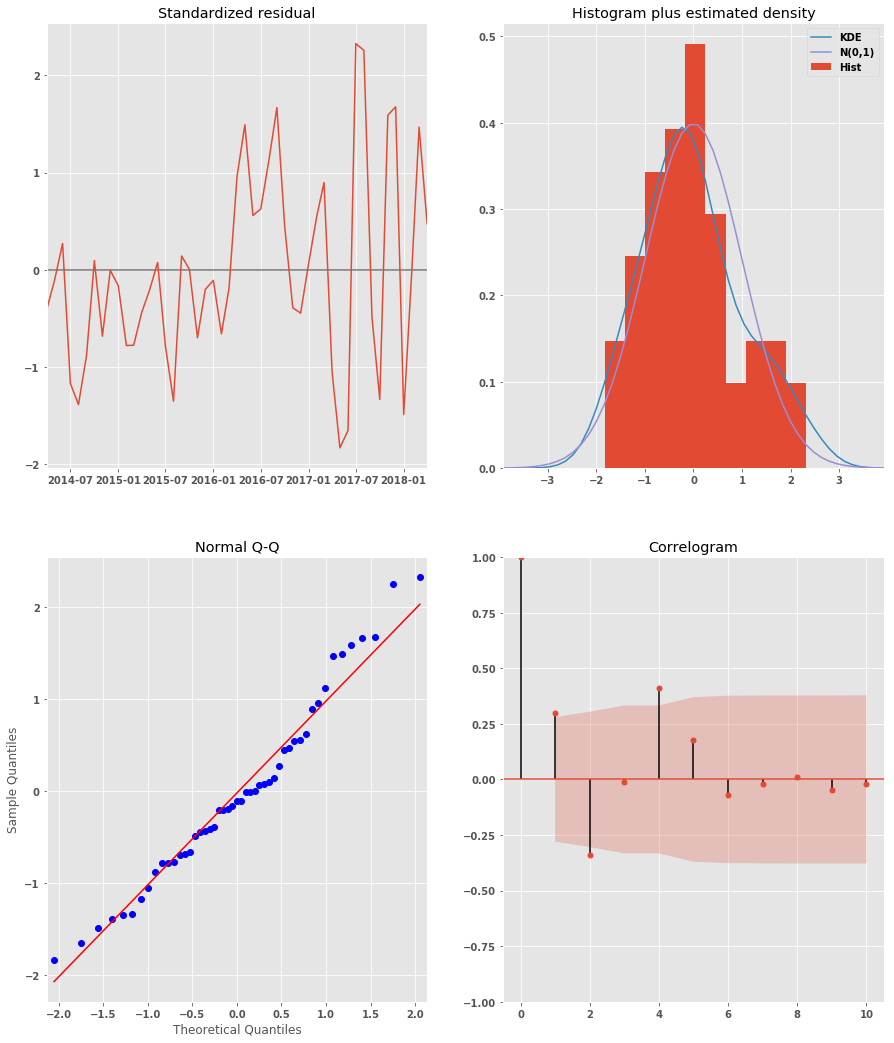

In [88]:
output.plot_diagnostics(figsize=(15, 18))
plt.show()

In [89]:
pred = output.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=False)
pred_conf = pred.conf_int()

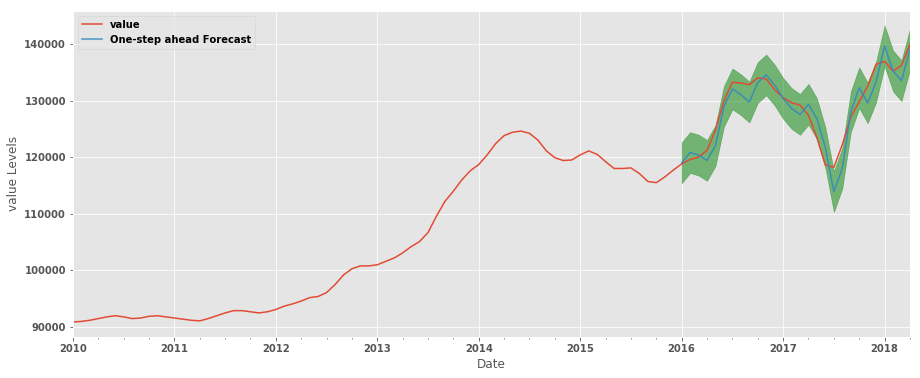

In [90]:
rcParams['figure.figsize'] = 15, 6

#Plot observed values
ax = mld['2010':].plot(label='observed')

#Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

#Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.5)

#Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('value Levels')
plt.legend()

plt.show()

In [91]:
value_forecasted = pred.predicted_mean
value_truth = mld['2016-01-01':]['value']

# Compute the mean square error
mse = ((value_forecasted - value_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 4800861.43


In [92]:
pred_dynamic = output.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=True, full_results=True)
pred_dynamic_conf = pred_dynamic.conf_int()

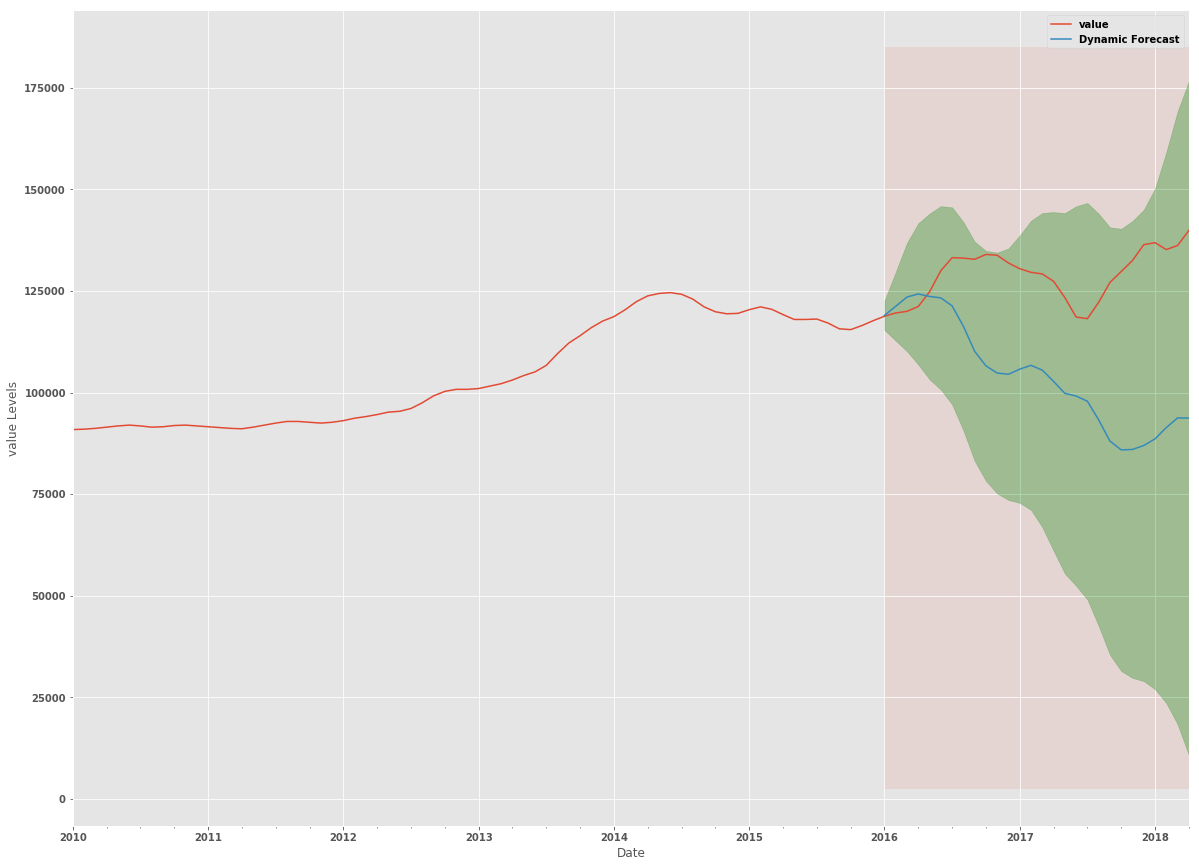

In [93]:
ax = mld['2010':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2016-01-01'), value_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('value Levels')

plt.legend()
plt.show()

In [94]:
value2_forecasted = pred_dynamic.predicted_mean
value2_truth = mld['2016-01-01':]['value']

# Compute the mean square error
mse = ((value2_forecasted - value2_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 859493500.67


In [95]:
# Get forecast 500 steps ahead in future
prediction = output.get_forecast(steps=24)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

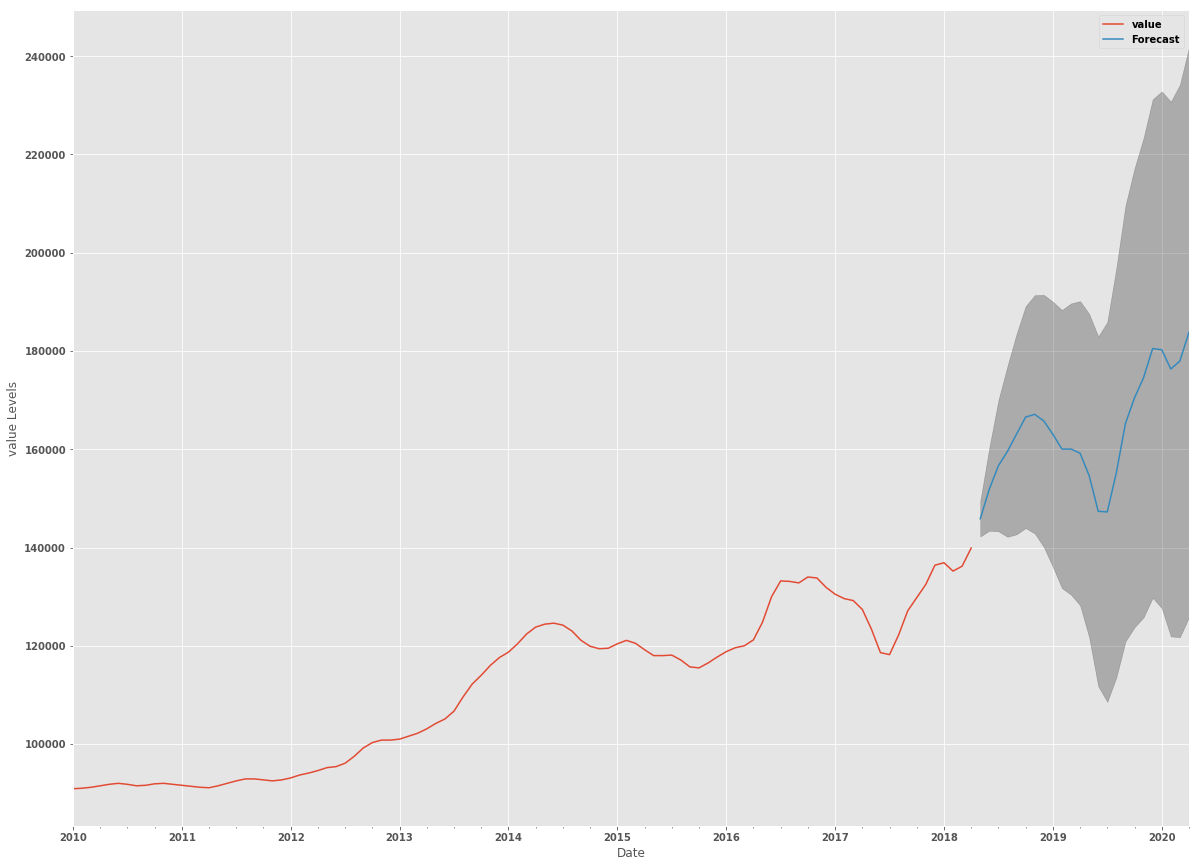

In [96]:
ax = mld.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('value Levels')

plt.legend()
plt.show()

# Step 6: Interpreting Results